# Linear Regression Models
This notebook fits regression models to the joined energy and weather data, finds the best "alpha" $\alpha$ parameters, and checks the features with the largest coefficients.

The results are summarized here:

### Ridge Regression
- Best alpha using the one-standard-error rule: 37.92690190732246
- Test MSE for Ridge: 1704523.0660031326
- Features with largest absolute coefficients:
    1. `temp_Madrid`
    2. `temp_max_Madrid`
    3. `temp_Valencia`

### Lasso Regression
- Best Alpha: 37.649358067924716
- Lowest MSE: 1576426.0529618268
- Features with largest absolute coefficients:
    1. `total load forecast`
    2. `humidity_Valencia`
    3. `temp_min_Valencia`

In [47]:
#Import libraries
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

#Visualization
#import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [49]:
# Read the joined energy + weather dataset
df = pd.read_csv('../Data/df_final.csv',index_col="time")

In [50]:
# Split dataset by features/label and train/validate and test
#X = df.drop(columns=['generation solar', 'generation wind onshore'])
X = df.drop(columns=['generation solar', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind onshore day ahead'])
ys = df['generation solar']

In [51]:
# Split the data into train and test based on specific time '2017-12-31 23:00:00+00:00'
def split_by_date(X, train_end_date):
    if not isinstance(train_end_date, pd.Timestamp):
        train_end_date = pd.Timestamp(train_end_date)

    # Convert index of X and y to Timestamp objects if they are strings
    if isinstance(X.index[0], str):
        X.index = pd.to_datetime(X.index)
        
    X_train = X[X.index <= train_end_date]
    X_test = X[X.index > train_end_date]
    return X_train, X_test

train_end_date = pd.to_datetime('2017-12-31 23:00:00+00:00')
X_train, X_test = split_by_date(X, train_end_date)
ys_train, ys_test = split_by_date(ys, train_end_date)

In [52]:
# Standardize the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [53]:
# Setup cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

## Ridge Regression

In [54]:
## Selecting 20 values of alpha
alphas = np.logspace(-6, 6, 20)

mse_scores_ridge = []
std_errors = []  # To store standard errors for each alpha

# Loop through alpha values
for alpha in alphas:
    model = make_pipeline(
        StandardScaler(),
        Ridge(alpha=alpha)
    )
    scores = cross_val_score(model, X_train, ys_train, cv=kf, scoring='neg_mean_squared_error')
    mse_scores_ridge.append(-1 * np.mean(scores))
    # Standard error calculation for each alpha's MSE across folds
    std_errors.append(np.std(scores) / np.sqrt(len(scores)))

# Use the SE for the alpha that gave the minimum MSE
min_mse = min(mse_scores_ridge)
min_mse_index = mse_scores_ridge.index(min_mse)
min_mse_se = std_errors[min_mse_index]
# print("min_mse_se", min_mse_se)

# Apply the one-standard-error rule
within_one_std = min_mse + min_mse_se

candidate_alphas = [alphas[i] for i, mse in enumerate(mse_scores_ridge) if mse <= within_one_std]

best_alpha_ridge = max(candidate_alphas)

print("candidate_alphas",candidate_alphas)
print(f"Best alpha using the one-standard-error rule: {best_alpha_ridge}")

candidate_alphas [1e-06, 4.281332398719396e-06, 1.8329807108324375e-05, 7.847599703514606e-05, 0.0003359818286283781, 0.0014384498882876629, 0.00615848211066026, 0.026366508987303555, 0.11288378916846883, 0.4832930238571752, 2.06913808111479, 8.858667904100814, 37.92690190732246]
Best alpha using the one-standard-error rule: 37.92690190732246


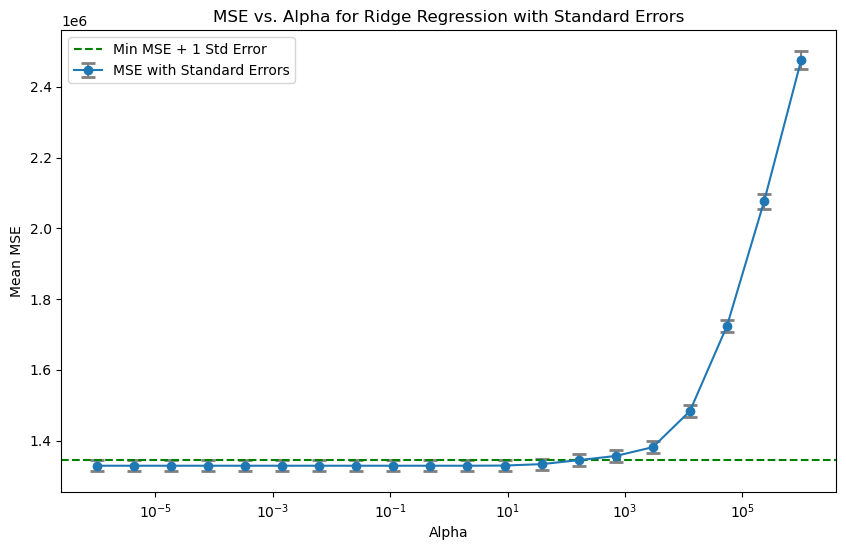

In [55]:
#PLOTTING

plt.figure(figsize=(10, 6))

# Plotting MSE vs Alpha with standard error bars
plt.errorbar(alphas, mse_scores_ridge, yerr=std_errors, fmt='-o', ecolor='gray', capsize=5, capthick=2, label='MSE with Standard Errors')

# Highlighting the best alpha according to the one-standard-error rule with a vertical line
# plt.axvline(x=best_alpha_ridge_one_se, color='red', linestyle='--', label=f'Best Alpha: {best_alpha_ridge}')

# Adding a horizontal line for one standard error above the minimum MSE
plt.axhline(y=within_one_std, color='green', linestyle='--', label='Min MSE + 1 Std Error')

plt.xlabel('Alpha')
plt.ylabel('Mean MSE')
plt.xscale('log')  # Alpha values are on a logarithmic scale
plt.title('MSE vs. Alpha for Ridge Regression with Standard Errors')
plt.legend()

plt.show()

In [56]:
# Ridge model with best alpha
ridge_model = make_pipeline(
    StandardScaler(),
    Ridge(alpha=best_alpha_ridge)
)
ridge_model.fit(X_train, ys_train)
ys_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(ys_test, ys_pred_ridge)

print(f"Test MSE for Ridge: {mse_ridge}")

Test MSE for Ridge: 1704523.0660031326


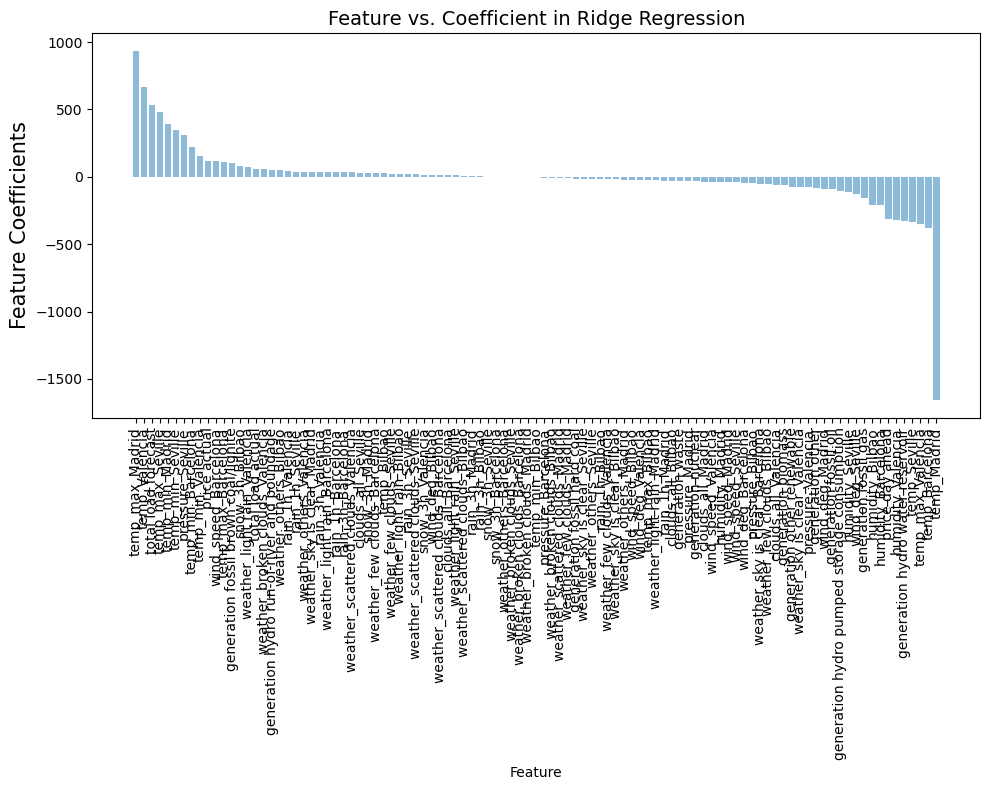

In [57]:
# Check coefficient sizes as measure of "feature importance"

# Get feature names
feature_names = X.columns

# Get feature coefficients
feature_coefficients = ridge_model[1].coef_
sorted_indices = np.argsort(feature_coefficients)[::-1]

# Create the plot
plt.figure(figsize=(10, 8))
plt.title('Feature vs. Coefficient in Ridge Regression', fontsize=14)
plt.bar(range(len(feature_coefficients)), feature_coefficients[sorted_indices], align='center', alpha=0.5)
plt.xticks(range(len(feature_coefficients)), feature_names[sorted_indices], rotation=90)
plt.ylabel('Feature Coefficients', fontsize=15)
plt.xlabel('Feature', fontsize=10)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()

## Lasso Regression

In [78]:
## selecting 100 values of alpha
alphas = np.logspace(-4, 4, 100)

alpha_values = []
mse_values = []
best_alpha_lasso = None
lowest_mse_lasso = np.inf

# Loop through alpha values
for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train, ys_train)
    ys_pred = lasso_model.predict(X_test)
    mse = mean_squared_error(ys_test, ys_pred)
    
    alpha_values.append(alpha)
    mse_values.append(mse)
    
    if mse < lowest_mse_lasso:
        best_alpha_lasso = alpha
        lowest_mse_lasso = mse

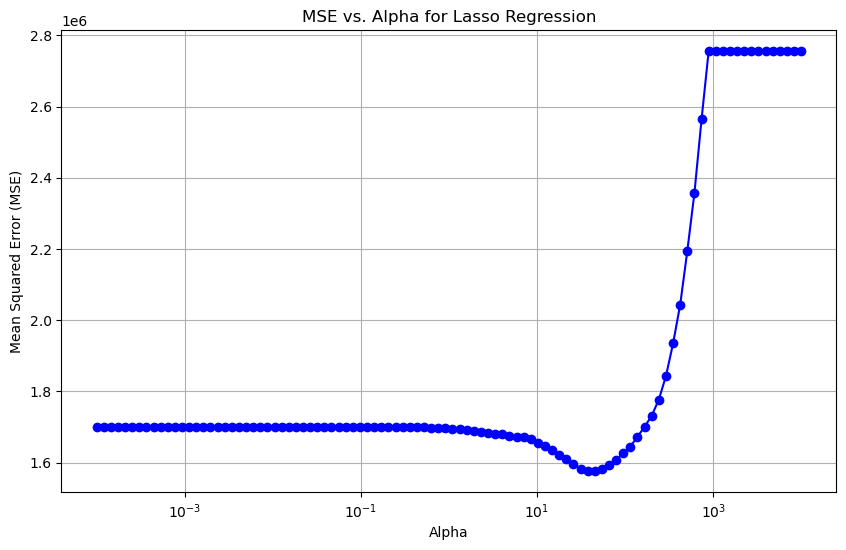

In [79]:
#PLOTTING
plt.figure(figsize=(10, 6))
plt.semilogx(alpha_values, mse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Alpha for Lasso Regression')
plt.grid(True)
plt.show()

In [80]:
print(f"Best Alpha: {best_alpha_lasso}")
print(f"Lowest MSE: {lowest_mse_lasso}")

Best Alpha: 37.649358067924716
Lowest MSE: 1576426.0529618268


In [81]:
# Lasso model with best alpha
best_lasso_model = make_pipeline(
    StandardScaler(),
    Lasso(alpha=best_alpha_lasso)
)
best_lasso_model.fit(X_train, ys_train)
ys_pred_lasso = best_lasso_model.predict(X_test)
mse_lasso = mean_squared_error(ys_test, ys_pred_lasso)

print(f"Test MSE for Ridge: {mse_lasso}")

Test MSE for Ridge: 1576426.0529618268


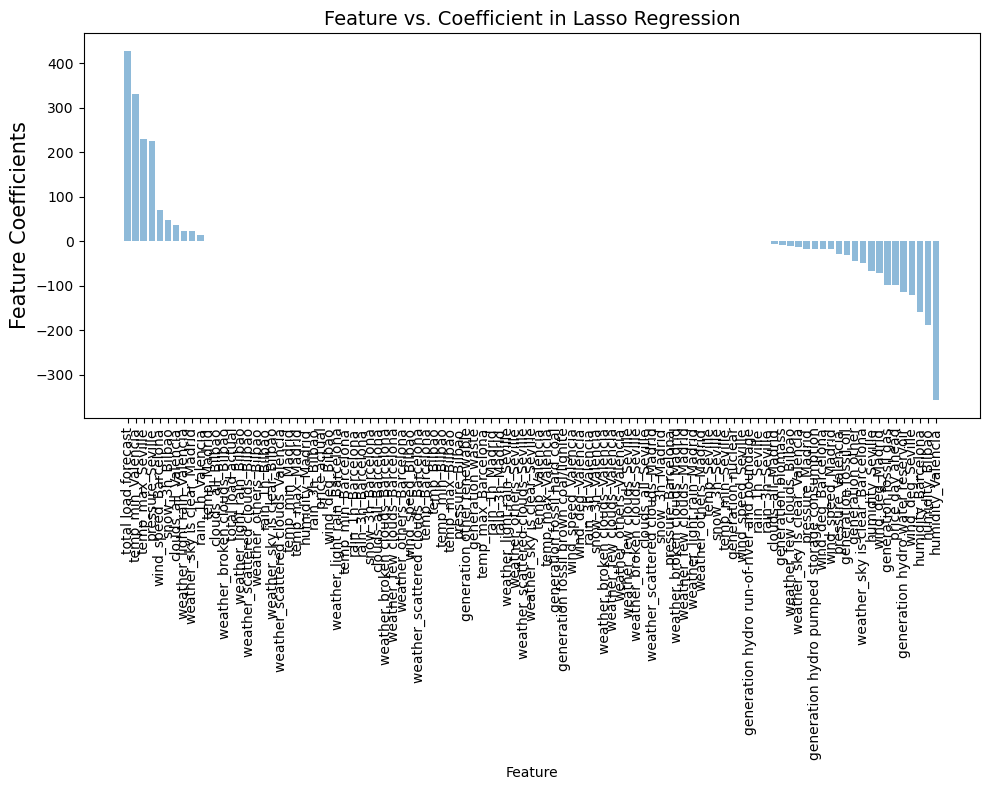

In [82]:
# Check coefficient sizes as measure of "feature importance"

# Get feature names
feature_names = X.columns

# Get feature coefficients
feature_coefficients = best_lasso_model[1].coef_
sorted_indices = np.argsort(feature_coefficients)[::-1]

# Create the plot
plt.figure(figsize=(10, 8))
plt.title('Feature vs. Coefficient in Lasso Regression', fontsize=14)
plt.bar(range(len(feature_coefficients)), feature_coefficients[sorted_indices], align='center', alpha=0.5)
plt.xticks(range(len(feature_coefficients)), feature_names[sorted_indices], rotation=90)
plt.ylabel('Feature Coefficients', fontsize=15)
plt.xlabel('Feature', fontsize=10)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()